# Importações

In [1]:
#!pip install scikit-learn shap pandas numpy matplotlib xgboost seaborn 

In [2]:
import pickle

import shap
import matplotlib.pyplot as plt

import pandas as pd 
import numpy as np  

# Pré-processamento e pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Modelos de ML
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Validação e busca de hiperparâmetros
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from scipy.stats import randint, uniform, loguniform

# Métricas
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score

# Transformadores personalizados
from transformers import DateFeatureExtractor, CapTransformer, RareCategoryGrouper, TopNMultiLabelTransformer

c:\Users\oxi\Documents\GitHub\projeto-pisi3\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Carregando dataset

In [3]:
df = pd.read_csv('../data/filmes_filtrados_credits.csv')
df = df.drop(columns=['popularity'])

# Dividindo os dados
- X_train, X_test, y_train, y_test

In [4]:
numerical_cols = df[['budget', 'runtime']].columns
categorical_col = ['original_language']
date_column = 'release_date'

X = df.drop(columns=['vote_average'])
y = df['vote_average']

# Dividindo o dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=87)

# Transformadores
- MultiLabelBinarize -> Generos Cinematográficos, Produtora e Atores
- Data -> Extrai o ano e o mês das datas
- Outliers -> Cap, Log + Cap, Winsorizer
- Agrupamento de categorias raras -> original language

In [ ]:
# Transformers personalizados por coluna
credits_transformer = TopNMultiLabelTransformer(top_n=60, prefix='credits')
genres_transformer = TopNMultiLabelTransformer(top_n=20, prefix='genre')
prod_companies_transformer = TopNMultiLabelTransformer(top_n=60, prefix='prod_company')

# Treinamento
- Modelo XGBRegressor
- Modelo SVR
- Modelo RandomForest

### Definindo Kf

In [6]:
# Definindo o KFold para o cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=87)

### XGBRegressor

In [27]:
# Numérico
num_pipeline = Pipeline([
    ('cap', CapTransformer(columns=numerical_cols)),
    ('scale', StandardScaler())
])

# Categórico (ex: original_language)
cat_pipeline = Pipeline([
    ('rare', RareCategoryGrouper(column='original_language', top_n=10, other_label='Other')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Pré-processamento geral com ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, categorical_col),
    ('credits', credits_transformer, 'credits'),
    ('genres', genres_transformer, 'genres'),
    ('prod_companies', prod_companies_transformer, 'production_companies')
], remainder='passthrough')  # passar colunas extras como ano/mês se já forem numéricas


pipeline = Pipeline([
    ('date', DateFeatureExtractor(date_column=date_column)),
    ('preprocess', preprocessor),
    ('regressor', XGBRegressor(objective='reg:squarederror', random_state=87, n_jobs=-1))
])

param_dist = {
    'regressor__n_estimators': randint(100, 300),
    'regressor__max_depth': randint(3, 10),
    'regressor__learning_rate': uniform(0.01, 0.3),
    'regressor__subsample': uniform(0.7, 0.3),
    'regressor__colsample_bytree': uniform(0.7, 0.3),
}


XGBRegressor_rand = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=30,
    cv=kf,
    scoring='r2',
    random_state=87,
    verbose=2,
    n_jobs=-1
)

XGBRegressor_rand.fit(X_train, y_train)

print("Melhores parâmetros:", XGBRegressor_rand.best_params_)
print("Melhor R² (validação cruzada):", XGBRegressor_rand.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Melhores parâmetros: {'regressor__colsample_bytree': np.float64(0.7408519783845126), 'regressor__learning_rate': np.float64(0.09251498554943016), 'regressor__max_depth': 5, 'regressor__n_estimators': 296, 'regressor__subsample': np.float64(0.9193104934988872)}
Melhor R² (validação cruzada): 0.3937536573751377


### SVR

In [8]:
# Numérico
num_pipeline = Pipeline([
    ('cap', CapTransformer(columns=numerical_cols)),
    ('scale', StandardScaler())
])

# Categórico
cat_pipeline = Pipeline([
    ('rare', RareCategoryGrouper(column='original_language', top_n=10, other_label='Other')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Pré-processamento completo
preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, categorical_col),
    ('credits', credits_transformer, 'credits'),
    ('genres', genres_transformer, 'genres'),
    ('prod_companies', prod_companies_transformer, 'production_companies')
], remainder='passthrough')  # mantém outras colunas (ex: year, month)



pipeline_svr = Pipeline([
    ('date', DateFeatureExtractor(date_column=date_column)),
    ('preprocess', preprocessor),
    ('regressor', SVR())
])

param_dist_svr = {
    'regressor__kernel': ['rbf', 'linear'],
    'regressor__C': loguniform(1e-2, 1e2),
    'regressor__epsilon': uniform(0.01, 0.3),
    'regressor__gamma': ['scale', 'auto']
}

svm_rand = RandomizedSearchCV(
    estimator=pipeline_svr,
    param_distributions=param_dist_svr,
    n_iter=20,
    cv=kf,
    scoring='r2',
    random_state=87,
    verbose=2,
    n_jobs=-1
)

svm_rand.fit(X_train, y_train)
print("Melhores parâmetros SVR:", svm_rand.best_params_)
print("Melhor R² (CV) SVR:", svm_rand.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Melhores parâmetros SVR: {'regressor__C': np.float64(4.217516020234043), 'regressor__epsilon': np.float64(0.29647041307396826), 'regressor__gamma': 'auto', 'regressor__kernel': 'rbf'}
Melhor R² (CV) SVR: 0.3571728120830269


### RandomForest

In [9]:
# Numérico
num_pipeline = Pipeline([
    ('cap', CapTransformer(columns=numerical_cols)),
    ('scale', StandardScaler())
])

# Categórico
cat_pipeline = Pipeline([
    ('rare', RareCategoryGrouper(column='original_language', top_n=10, other_label='Other')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Pré-processamento completo
preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, categorical_col),
    ('credits', credits_transformer, 'credits'),
    ('genres', genres_transformer, 'genres'),
    ('prod_companies', prod_companies_transformer, 'production_companies')
], remainder='passthrough')  # mantém outras colunas (ex: year, month)

pipeline_rf = Pipeline([
    ('date', DateFeatureExtractor(date_column=date_column)),
    ('preprocess', preprocessor),
    ('regressor', RandomForestRegressor(random_state=87, n_jobs=-1))
])

param_dist_rf = {
    'regressor__n_estimators': randint(100, 500),
    'regressor__max_depth': randint(3, 20),
    'regressor__min_samples_split': randint(2, 10),
    'regressor__min_samples_leaf': randint(1, 10),
    'regressor__max_features': ['sqrt', 'log2', None]
}

rf_rand = RandomizedSearchCV(
    estimator=pipeline_rf,
    param_distributions=param_dist_rf,
    n_iter=30,
    cv=kf,
    scoring='r2',
    error_score='raise',
    random_state=87,
    verbose=2,
    n_jobs=-1
)

rf_rand.fit(X_train, y_train)
print("Melhores parâmetros RF:", rf_rand.best_params_)
print("Melhor R² (CV) RF:", rf_rand.best_score_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Melhores parâmetros RF: {'regressor__max_depth': 14, 'regressor__max_features': None, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 376}
Melhor R² (CV) RF: 0.3674570572650846


# Avaliação dos modelos

In [10]:
def evaluate_model(model_name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    return {
        'Modelo': model_name,
        'R²': r2_score(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MedAE': median_absolute_error(y_test, y_pred)
    }


In [28]:
results = []

results.append(evaluate_model("XGBRegressor", XGBRegressor_rand.best_estimator_, X_test, y_test))
results.append(evaluate_model("SVR", svm_rand.best_estimator_, X_test, y_test))
results.append(evaluate_model("RandomForestRegressor", rf_rand.best_estimator_, X_test, y_test))

results_df = pd.DataFrame(results)
print(results_df)

                  Modelo        R²       MAE      RMSE     MedAE
0           XGBRegressor  0.400018  0.544662  0.706352  0.439729
1                    SVR  0.353191  0.563317  0.733399  0.462908
2  RandomForestRegressor  0.357179  0.563541  0.731134  0.459860


# Graficos

## Shap

Valores SHAP calculados com sucesso. Gerando gráficos...


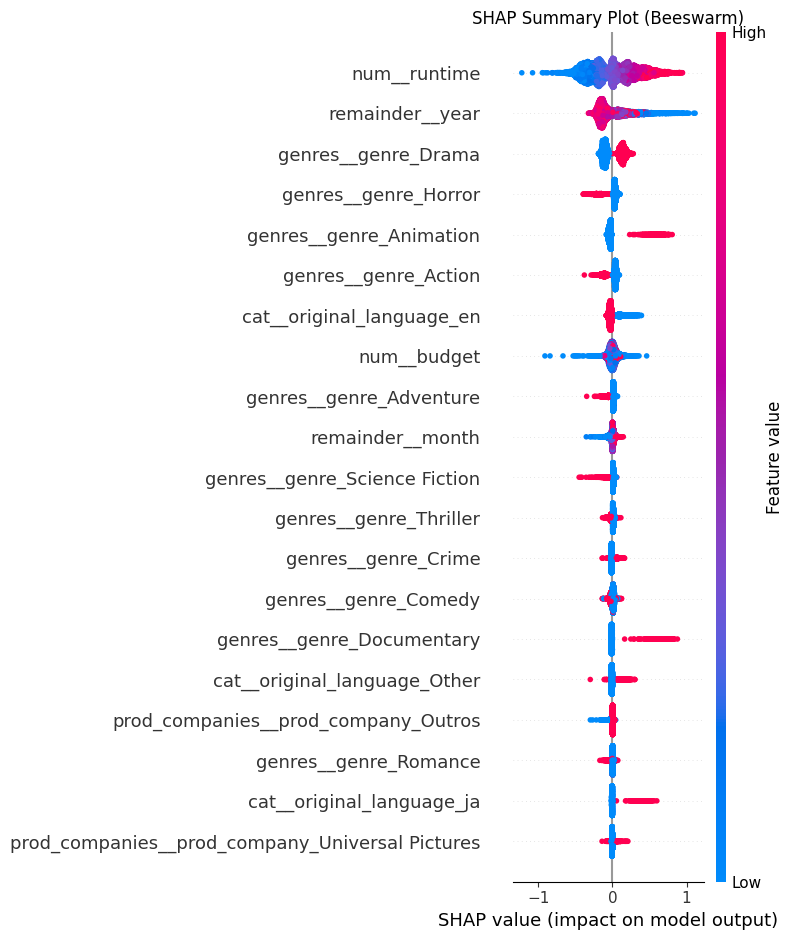

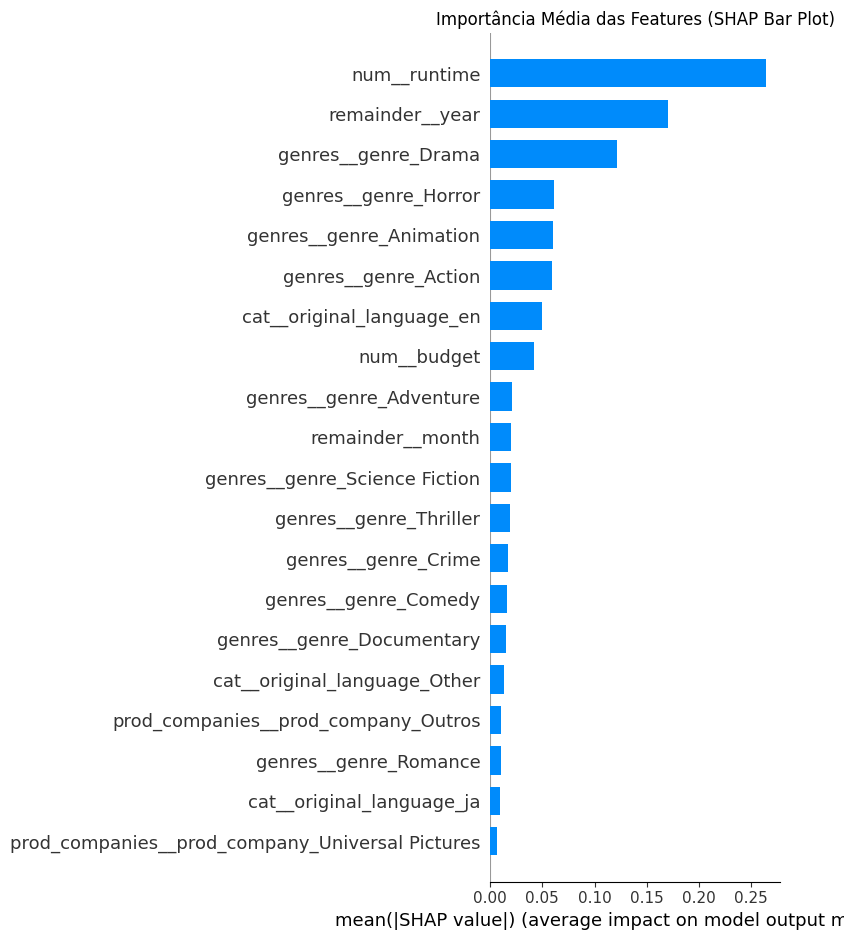

In [29]:
import shap
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline # Importe o Pipeline

# --- Assumindo que seu código de treinamento já foi executado ---
# XGBRegressor_rand.fit(X_train, y_train)

# 1. Obter o melhor pipeline treinado
best_pipeline = XGBRegressor_rand.best_estimator_

# 2. Criar um pipeline APENAS com os passos de pré-processamento
#    Isso garante que 'DateFeatureExtractor' rode antes do 'ColumnTransformer'.
#    O 'steps[:-1]' pega todos os passos, exceto o último (o regressor).
preprocessing_pipeline = Pipeline(best_pipeline.steps[:-1])

# Agora, transforme os dados usando este pipeline de pré-processamento completo
X_train_transformed = preprocessing_pipeline.transform(X_train)


# 3. Obter os nomes das features do ColumnTransformer (que é o passo 'preprocess')
#    O método get_feature_names_out() do ColumnTransformer inclui as colunas do 'remainder=passthrough'
col_transformer = best_pipeline.named_steps['preprocess']
feature_names = col_transformer.get_feature_names_out()


# 4. Criar um DataFrame com os dados transformados para melhor visualização no SHAP
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=feature_names)


# 5. Extrair o modelo final e calcular os valores SHAP
xgb_model = best_pipeline.named_steps['regressor']
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer(X_train_transformed_df) # A API moderna do SHAP usa o explainer como uma função

print("Valores SHAP calculados com sucesso. Gerando gráficos...")

# 6. Gerar os gráficos
plt.figure()
plt.title("SHAP Summary Plot (Beeswarm)")
shap.summary_plot(shap_values, X_train_transformed_df, show=False)
plt.tight_layout() # Ajusta o layout para evitar sobreposição
plt.show()

plt.figure()
plt.title("Importância Média das Features (SHAP Bar Plot)")
shap.summary_plot(shap_values, X_train_transformed_df, plot_type="bar", show=False)
plt.tight_layout()
plt.show()

## Importance

In [30]:
feature_importance = np.abs(shap_values.values).mean(axis=0)
# 2. Crie o DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'SHAP Importance': feature_importance
})

# 3. Ordene o DataFrame pela coluna 'SHAP Importance' do maior para o menor
sorted_importance_df = importance_df.sort_values(
    by='SHAP Importance', 
    ascending=False
).reset_index(drop=True)

# 4. Exiba o DataFrame resultante
print("Ranking de Importância das Features (baseado em SHAP):")
# Usar to_string() para garantir que todas as linhas sejam exibidas
pd.set_option('display.max_rows', None)
print(len(sorted_importance_df))
display(sorted_importance_df)  # Use display para melhor visualização no Jupyter

Ranking de Importância das Features (baseado em SHAP):
237


,Feature,SHAP Importance
0,num__runtime,0.264621
1,remainder__year,0.170047
2,genres__genre_Drama,0.121635
3,genres__genre_Horror,0.060678
4,genres__genre_Animation,0.060071
5,genres__genre_Action,0.059458
6,cat__original_language_en,0.049184
7,num__budget,0.041705
8,genres__genre_Adventure,0.020611
9,remainder__month,0.020287


# Gerando Pickle

In [ ]:
with open(best_model_sem_populairy.pkl', 'wb') as f:
    pickle.dump(XGBRegressor_rand, f)

In [14]:
'''
with open('xgb_pipeline.pkl', 'wb') as f:
    pickle.dump(XGBRegressor_rand, f)

with open('svr_pipeline.pkl', 'wb') as f:
    pickle.dump(svm_rand, f)

with open('rf_pipeline.pkl', 'wb') as f:
    pickle.dump(rf_rand, f)
'''

"\nwith open('xgb_pipeline.pkl', 'wb') as f:\n    pickle.dump(XGBRegressor_rand, f)\n\nwith open('svr_pipeline.pkl', 'wb') as f:\n    pickle.dump(svm_rand, f)\n\nwith open('rf_pipeline.pkl', 'wb') as f:\n    pickle.dump(rf_rand, f)\n"